In [1]:
from lib import run_definition
from lib import run_result_location
from lib import constants
from lib import run
from os import path
import json
import glob
import numpy as np
import pandas as pd
from jsonpath_ng import jsonpath, parse
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go


%matplotlib inline
#global defaults of graphics size
plt.rcParams["figure.figsize"] = [50, 50]

#Define run_id
#run_id = "2020-10-23-15-59-41"
run_id = "2020-10-23-16-10-36"

#point to test result folder containing runs
#location = perfmodel.RunResultLocation("../testresults/azure.1-auto-standalone")
location = run_result_location.RunResultLocation("../testresults/aws.1-auto-standalone")

runDefinition = run_definition.RunDefinition(location)
runDefinition.process_run_samples()
run = runDefinition.find_run(run_id)
meta = run.run_meta
df_latencies = pd.DataFrame(data={'run1': run.export_latency_node_distinct_latencies()})
df_broker_latencies = pd.DataFrame(data={'run1': run.export_broker_node_distinct_latencies()})
df_ping = pd.DataFrame(run.export_ping_series(constants.c_ping_all_metrics))

## Single Detailed Run Analytics

CONFIDENTIAL | NOT FOR DISTRIBUTION | DATA NOT VALIDATED

Cloudprovider: {{meta.cloud_provider}}

Infrastructure: {{meta.infrastructure}}

Run name: {{meta.run_name}}

Run Id: {{meta.run_id}}

Started: {{meta.ts_run_start}}

Ended: {{meta.ts_run_end}}

Duration: {{meta.run_duration_sec()}}


# Key Metrics

### Latency Node Basic Stats

In [2]:
run1_series = df_latencies['run1']
run1_series.describe()

count    400000.000000
mean        268.369073
std          63.975137
min         142.000000
25%         230.000000
50%         247.000000
75%         287.000000
max        2819.000000
Name: run1, dtype: float64

### Broker Node Basic Stats

In [3]:
broker_run1_series = df_broker_latencies['run1']
broker_run1_series.describe()

count    400000.000000
mean        219.195857
std          62.611198
min          93.000000
25%         178.000000
50%         195.000000
75%         239.000000
max        1193.000000
Name: run1, dtype: float64

### Latency Node Quantiles

In [4]:
q1 = run1_series.quantile(q=[0.05,0.1,0.25,0.5,0.75,0.9,0.99,0.995,0.999,0.9999,0.99995,0.99999])
q1

0.05000     208.00000
0.10000     217.00000
0.25000     230.00000
0.50000     247.00000
0.75000     287.00000
0.90000     354.00000
0.99000     496.00000
0.99500     567.00000
0.99900     662.00000
0.99990     754.00050
0.99995     810.00040
0.99999    1760.00062
Name: run1, dtype: float64

### Broker Node Quantiles

In [5]:
broker_q1 = broker_run1_series.quantile(q=[0.05,0.1,0.25,0.5,0.75,0.9,0.99,0.995,0.999,0.9999,0.99995,0.99999])
broker_q1






0.05000    162.00000
0.10000    167.00000
0.25000    178.00000
0.50000    195.00000
0.75000    239.00000
0.90000    312.00000
0.99000    433.00000
0.99500    465.00000
0.99900    544.00000
0.99990    642.00030
0.99995    692.00025
0.99999    870.00046
Name: run1, dtype: float64

<Figure size 1800x1080 with 0 Axes>

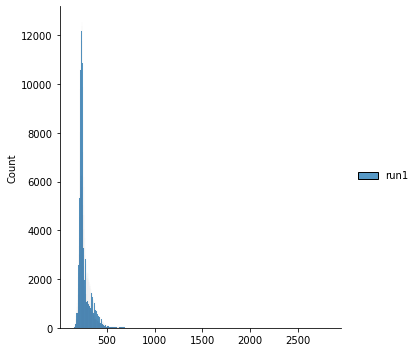

In [6]:
plt.figure(figsize=(25,15))
sns.displot(data=df_latencies)

<Figure size 1800x1080 with 0 Axes>

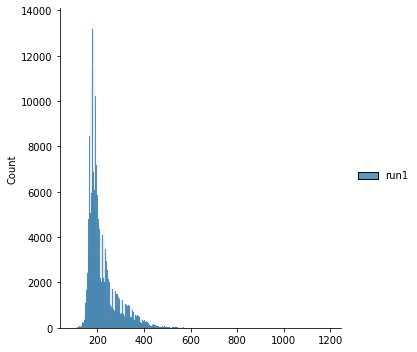

In [7]:
plt.figure(figsize=(25,15))
sns.displot(data=df_broker_latencies)


## DELTA Series

In [8]:
delta_index_latencies = run.export_latency_node_delta_index_latencies(lambda latency: latency >= q1.get(0.99))
df_delta_index_latencies = pd.DataFrame(data={"delta":delta_index_latencies})
df_delta_index_latencies['delta'].describe()

count    4033.000000
mean       94.915943
std       293.571487
min         1.000000
25%        14.000000
50%        47.000000
75%        70.000000
max      6818.000000
Name: delta, dtype: float64

<Figure size 1800x1080 with 0 Axes>

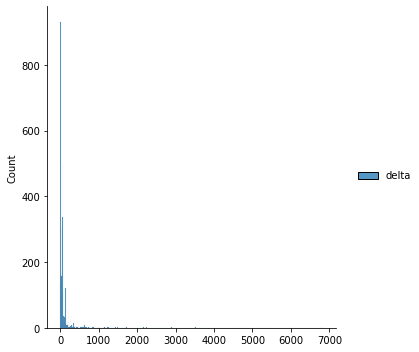

In [9]:
plt.figure(figsize=(25,15))
sns.displot(data=df_delta_index_latencies)

In [10]:
lat_series_length = run.export_latency_node_series_length_latencies(lambda latency: latency >= q1.get(0.99))
s = lat_series_length[constants.k_latency_series_length]
g = lat_series_length[constants.k_latency_gap_length]
df_series_length = pd.DataFrame(data={"series_length": s})
df_series_length = pd.DataFrame(data={"gap_length": g})
df_series_length

,gap_length
0,21
1,110
2,26
3,68
4,12
...,...
3993,40
3994,40
3995,82
3996,782
